# Libraries

In [1]:
from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
from collections import Counter

from pathlib import Path
import pandas as pd
from collections import Counter

from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_auc_score, average_precision_score

from pathlib import Path
import numpy as np
import pandas as pd

from pathlib import Path
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

from pathlib import Path
import numpy as np
import pandas as pd
import joblib, json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix
)

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, 
    PrecisionRecallDisplay, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay,
    confusion_matrix, ConfusionMatrixDisplay
)

# Functions

In [2]:
def print_results(pipe, X_test, y_test, thr_star):

    # Préparation des 3 sous-graphes côte à côte
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Courbe ROC
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=axs[0])
    axs[0].set_title("Courbe ROC - Baseline A")
    axs[0].grid(True)

    # Courbe Précision-Rappel
    PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, ax=axs[1])
    axs[1].set_title("Courbe Précision-Rappel - Baseline A")
    axs[1].grid(True)

    # Matrice de confusion avec seuil choisi
    proba_test = pipe.predict_proba(X_test)[:, 1]
    y_pred_thr = (proba_test >= thr_star).astype(int)
    cm = confusion_matrix(y_test, y_pred_thr)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Risque", "Risque"])
    disp.plot(ax=axs[2], cmap="Blues", values_format="d", colorbar=False)
    axs[2].set_title("Matrice de confusion - Seuil métier (FN=10xFP)")
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()


In [3]:
def create_baseline(baseline_name, df,feature_list,random_state=42):

    # Dossiers
    global ROOT
    global CFG

    # 2) Colonnes à utiliser
    used_cols = ["SK_ID_CURR", "TARGET"] + feature_list
    df = df[[col for col in used_cols if col in df.columns]].copy()

    # 3) Séparation X / y
    X = df.drop(columns=["SK_ID_CURR", "TARGET"])
    y = df["TARGET"].astype(int).values

    # 4) Train/test split stratifié
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # 5) Pipeline complet
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])
    pipe.fit(X_train, y_train)

    # 6) Prédictions + métriques
    proba = pipe.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, proba)
    pr_auc  = average_precision_score(y_test, proba)
    print(f"ROC AUC  = {roc_auc:.3f}")
    print(f"PR AUC   = {pr_auc:.3f}")

    # 7) Fonction seuil métier : FN = 10 × FP
    def seuil_métier(y_true, proba, cost_fn=10.0, cost_fp=1.0):
        thresholds = np.linspace(0, 1, 1001)
        best_cost = float("inf")
        best_thr  = 0.5
        for thr in thresholds:
            y_pred = (proba >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            cost = fn * cost_fn + fp * cost_fp
            if cost < best_cost:
                best_cost = cost
                best_thr = thr
        return best_thr, best_cost

    thr_star, cost_star = seuil_métier(y_test, proba, cost_fn=10.0, cost_fp=1.0)
    y_pred = (proba >= thr_star).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(f"\nSeuil métier choisi : {thr_star:.3f}")
    print(f"Coût total (FN=10xFP): {cost_star:.0f}")
    print(f"Confusion : TP={tp} | FP={fp} | FN={fn} | TN={tn}")

    # 8) Sauvegarde modèle + méta
    joblib.dump(pipe, f"{ROOT}/models/{baseline_name}_personal_and_history.joblib")
    (ROOT / "models").mkdir(parents=True, exist_ok=True)

    with open(f"{CFG}/{baseline_name}_meta.json", "w") as f:
        json.dump({
            "features": [col for col in X.columns],
            "threshold_business": round(thr_star, 4),
            "business_costs": {"FN": 10.0, "FP": 1.0},
            "auc_roc": round(roc_auc, 4),
            "auc_pr": round(pr_auc, 4),
            "confusion_matrix": {"TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn)}
        }, f, indent=2)

    print(f"Modèle {baseline_name} + méta enregistrés.")
    print_results(pipe,X_test,y_test,thr_star)


# 01 — EDA

## Amorçage

In [4]:
# Racine projet
ROOT = Path.cwd() if (Path.cwd() / "data" / "raw").exists() else Path.cwd().parent
RAW  = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)
CFG  = ROOT / "config";
CFG.mkdir(exist_ok=True)

# Lister les CSV présents
csvs = sorted(p.name for p in RAW.glob("*.csv"))
print("CSV trouvés    :", len(csvs))
print(csvs)


CSV trouvés    : 10
['HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv', 'sample_submission.csv']


## Répartition cible de train

Lignes, colonnes : (307511, 2)
Comptes par classe : {0: 282686, 1: 24825}
Prévalence (classe 1) : 8.07%


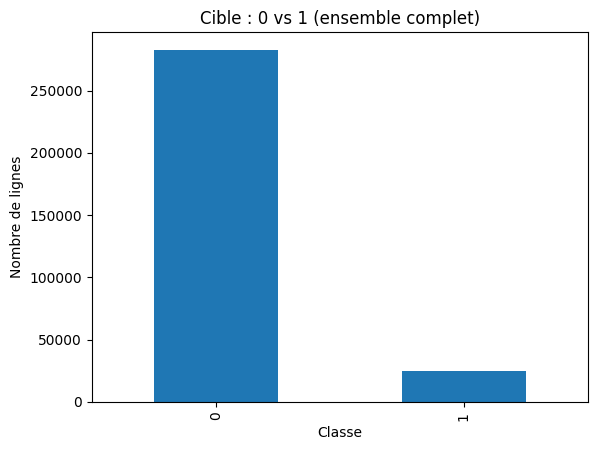

In [5]:
# Cellule 2 — Cible : 0 vs 1
train = pd.read_csv(RAW/"application_train.csv", usecols=["SK_ID_CURR","TARGET"])
print("Lignes, colonnes :", train.shape)

vc = train["TARGET"].value_counts().sort_index()
prev = train["TARGET"].mean()

print("Comptes par classe :", vc.to_dict())
print(f"Prévalence (classe 1) : {prev:.2%}")

vc.plot(kind="bar")
plt.title("Cible : 0 vs 1 (ensemble complet)")
plt.xlabel("Classe")
plt.ylabel("Nombre de lignes")
plt.show()

## Features "bureau"

In [6]:
# 1) Table maîtresse
train = pd.read_csv(RAW/"application_train.csv", usecols=["SK_ID_CURR","TARGET"])
print("train:", train.shape)

# 2) Compte des lignes de bureau_balance par SK_ID_BUREAU (lecture par morceaux)
bb_counts = Counter()
for chunk in pd.read_csv(RAW/"bureau_balance.csv", chunksize=500_000):
    vc = chunk["SK_ID_BUREAU"].value_counts()
    for k, v in vc.items():
        bb_counts[k] += int(v)
bb_per_bureau = pd.DataFrame({"SK_ID_BUREAU": list(bb_counts.keys()),
                              "bb_count": list(bb_counts.values())})
print("bb_per_bureau:", bb_per_bureau.shape)

# 3) Join vers bureau pour récupérer SK_ID_CURR
bureau = pd.read_csv(RAW/"bureau.csv", usecols=["SK_ID_CURR","SK_ID_BUREAU"])
bureau_enriched = bureau.merge(bb_per_bureau, on="SK_ID_BUREAU", how="left")
bureau_enriched["bb_count"] = bureau_enriched["bb_count"].fillna(0)

# 4) Agrégation au niveau client (2 features)
bureau_feat = (bureau_enriched
               .groupby("SK_ID_CURR")
               .agg(n_bureau=("SK_ID_BUREAU","count"),
                    n_bureau_months=("bb_count","sum"))
               .reset_index())
print("bureau_feat:", bureau_feat.shape)

# 5) Merge avec la table maîtresse + sauvegarde
train_plus = train.merge(bureau_feat, on="SK_ID_CURR", how="left").fillna(0)
print("train_plus:", train_plus.shape)

out_path = PROC / "train_plus_bureau.csv"
train_plus.to_csv(out_path, index=False)
print("Écrit :", out_path)

train: (307511, 2)
bb_per_bureau: (817395, 2)
bureau_feat: (305811, 3)
train_plus: (307511, 4)
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\data\processed\train_plus_bureau.csv


## Features "previous_*" (compteurs simples par client) + sauvegarde

In [7]:
# Repartition du fichier créé à l'étape précédente
base = pd.read_csv(PROC / "train_plus_bureau.csv")  # contient SK_ID_CURR, TARGET, n_bureau, n_bureau_months
print("base:", base.shape)

# Table "previous_application" (clé vers client et vers SK_ID_PREV)
prev = pd.read_csv(RAW / "previous_application.csv", usecols=["SK_ID_CURR","SK_ID_PREV"])
print("previous_application:", prev.shape)

# Fonction utilitaire: compter par SK_ID_PREV (lecture par morceaux pour limiter la RAM)
def count_by_prev(csv_filename, key="SK_ID_PREV", chunksize=500_000):
    cnt = Counter()
    for chunk in pd.read_csv(RAW / csv_filename, chunksize=chunksize):
        vc = chunk[key].value_counts()
        for k, v in vc.items():
            cnt[k] += int(v)
    return pd.DataFrame({key: list(cnt.keys()), "count": list(cnt.values())})

# Compteurs par SK_ID_PREV pour les 3 tables liées
inst = count_by_prev("installments_payments.csv"); inst.rename(columns={"count":"n_inst_pay"}, inplace=True)
posc = count_by_prev("POS_CASH_balance.csv");     posc.rename(columns={"count":"n_pos_cash"}, inplace=True)
ccb  = count_by_prev("credit_card_balance.csv");  ccb.rename(columns={"count":"n_ccb"}, inplace=True)
print("inst:", inst.shape, "posc:", posc.shape, "ccb:", ccb.shape)

# Joindre aux prev puis agréger au niveau client
prev_enriched = (prev
                 .merge(inst, on="SK_ID_PREV", how="left")
                 .merge(posc, on="SK_ID_PREV", how="left")
                 .merge(ccb,  on="SK_ID_PREV", how="left")
                 .fillna(0))

prev_feat = (prev_enriched
             .groupby("SK_ID_CURR")
             .agg(n_prev=("SK_ID_PREV","count"),
                  n_inst_pay=("n_inst_pay","sum"),
                  n_pos_cash=("n_pos_cash","sum"),
                  n_ccb=("n_ccb","sum"))
             .reset_index())

print("prev_feat:", prev_feat.shape)
display(prev_feat.head())

# Fusion finale avec la base et sauvegarde
final_df = base.merge(prev_feat, on="SK_ID_CURR", how="left").fillna(0)
print("final_df:", final_df.shape)

out_path = PROC / "train_plus_bureau_prev.csv"
final_df.to_csv(out_path, index=False)
print("Écrit :", out_path)

base: (307511, 4)
previous_application: (1670214, 2)
inst: (997752, 2) posc: (936325, 2) ccb: (104307, 2)
prev_feat: (338857, 5)


,SK_ID_CURR,n_prev,n_inst_pay,n_pos_cash,n_ccb
0,100001,1,4.0,5.0,0.0
1,100002,1,19.0,19.0,0.0
2,100003,3,25.0,28.0,0.0
3,100004,1,3.0,4.0,0.0
4,100005,2,9.0,11.0,0.0


final_df: (307511, 8)
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\data\processed\train_plus_bureau_prev.csv


## Features personnelles + flag is_new_to_credit

In [8]:
# 1) Base clients + cible
app = pd.read_csv(RAW / "application_train.csv")

# 2) Nettoyages rapides (conventions Home Credit)
# 365243 = placeholder "inconnu" -> NaN
app["DAYS_EMPLOYED"] = app["DAYS_EMPLOYED"].replace(365243, np.nan)

# 3) Features personnelles (disponibles pour nouveaux clients)
eps = 1e-9  # évite division par zéro
features_perso = pd.DataFrame({
    "SK_ID_CURR": app["SK_ID_CURR"],
    "TARGET": app["TARGET"],
    # ratios revenus / charges
    "credit_income_perc": app["AMT_CREDIT"] / (app["AMT_INCOME_TOTAL"] + eps),
    "annuity_income_perc": app["AMT_ANNUITY"] / (app["AMT_INCOME_TOTAL"] + eps),
    "goods_price_income_perc": app["AMT_GOODS_PRICE"] / (app["AMT_INCOME_TOTAL"] + eps),
    # âges (valeurs positives en années)
    "age_years": -app["DAYS_BIRTH"] / 365.25,
    "employed_years": -app["DAYS_EMPLOYED"] / 365.25,
    # sources externes (très prédictives dans HC)
    "ext1": app.get("EXT_SOURCE_1"),
    "ext2": app.get("EXT_SOURCE_2"),
    "ext3": app.get("EXT_SOURCE_3"),
    # structure familiale simple
    "cnt_children": app.get("CNT_CHILDREN"),
    "cnt_family_members": app.get("CNT_FAM_MEMBERS"),
})

# 4) Merge sur la table de travail actuelle (final_df) si elle existe, sinon on part de features_perso
try:
    final_df  # noqa: F821
    base = final_df.copy()
except NameError:
    base = features_perso[["SK_ID_CURR", "TARGET"]].copy()

# 5) Ajout/MAJ des features personnelles
final_df = base.merge(features_perso, on=["SK_ID_CURR","TARGET"], how="left")

# 6) Flag "nouveau client" (pas d'historique)
# On se base sur les features d'historique si elles existent, sinon on met 1 (nouveau) par défaut.
for col in ["n_prev_apps", "n_bureau"]:
    if col not in final_df.columns:
        final_df[col] = 0  # assure la présence pour le calcul du flag

final_df["is_new_to_credit"] = ((final_df["n_prev_apps"].fillna(0) == 0) &
                                (final_df["n_bureau"].fillna(0) == 0)).astype(int)

# 7) Sauvegarde
out = PROC / "train_features_v1.csv"
final_df.to_csv(out, index=False)
print("Écrit :", out)
final_df.head(3)


Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_scoring\data\processed\train_features_v1.csv


,SK_ID_CURR,TARGET,n_bureau,n_bureau_months,n_prev,n_inst_pay,n_pos_cash,n_ccb,credit_income_perc,annuity_income_perc,goods_price_income_perc,age_years,employed_years,ext1,ext2,ext3,cnt_children,cnt_family_members,n_prev_apps,is_new_to_credit
0,100002,1,8.0,110.0,1.0,19.0,19.0,0.0,2.007889,0.121978,1.733333,25.902806,1.744011,0.083037,0.262949,0.139376,0,1.0,0,0
1,100003,0,4.0,0.0,3.0,25.0,28.0,0.0,4.790750,0.132217,4.183333,45.900068,3.252567,0.311267,0.622246,NaN,0,2.0,0,0
2,100004,0,2.0,0.0,1.0,3.0,4.0,0.0,2.000000,0.100000,2.000000,52.145106,0.616016,NaN,0.555912,0.729567,0,1.0,0,0


In [9]:
final_df.describe()

,SK_ID_CURR,TARGET,n_bureau,n_bureau_months,n_prev,n_inst_pay,n_pos_cash,n_ccb,credit_income_perc,annuity_income_perc,goods_price_income_perc,age_years,employed_years,ext1,ext2,ext3,cnt_children,cnt_family_members,n_prev_apps,is_new_to_credit
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307499.000000,307233.000000,307511.000000,252137.000000,134133.000000,3.068510e+05,246546.000000,307511.000000,307509.000000,307511.0,307511.000000
mean,278180.518577,0.080729,4.765114,47.808410,4.597237,34.379977,26.834012,7.658240,3.957570,0.180930,3.544322,43.906900,6.527500,0.502130,5.143927e-01,0.510853,0.417052,2.152665,0.0,0.143149
std,102790.175348,0.272419,4.496199,113.735347,4.180015,35.890085,23.808168,19.488807,2.689728,0.094574,2.427708,11.947950,6.402081,0.211062,1.910602e-01,0.194844,0.722121,0.910682,0.0,0.350226
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004808,0.000224,0.003885,20.503765,-0.000000,0.014568,8.173617e-08,0.000527,0.000000,1.000000,0.0,0.000000
25%,189145.500000,0.000000,1.000000,0.000000,2.000000,11.000000,11.000000,0.000000,2.018667,0.114782,1.840000,33.984942,2.099932,0.334007,3.924574e-01,0.370650,0.000000,2.000000,0.0,0.000000
50%,278202.000000,0.000000,4.000000,0.000000,3.000000,22.000000,20.000000,0.000000,3.265067,0.162833,2.941176,43.121150,4.511978,0.505998,5.659614e-01,0.535276,0.000000,2.000000,0.0,0.000000
75%,367142.500000,0.000000,7.000000,29.000000,6.000000,45.000000,37.000000,2.000000,5.159880,0.229067,4.615385,53.886379,8.692676,0.675053,6.636171e-01,0.669057,1.000000,3.000000,0.0,0.000000
max,456255.000000,1.000000,116.000000,2657.000000,73.000000,350.000000,285.000000,119.000000,84.736842,1.875965,84.736842,69.073238,49.040383,0.962693,8.549997e-01,0.896010,19.000000,20.000000,0.0,1.000000


ROC AUC  = 0.730
PR AUC   = 0.211

Seuil métier choisi : 0.538
Coût total (FN=10xFP): 34722
Confusion : TP=2977 | FP=14842 | FN=1988 | TN=41696
Modèle Baseline_A + méta enregistrés.


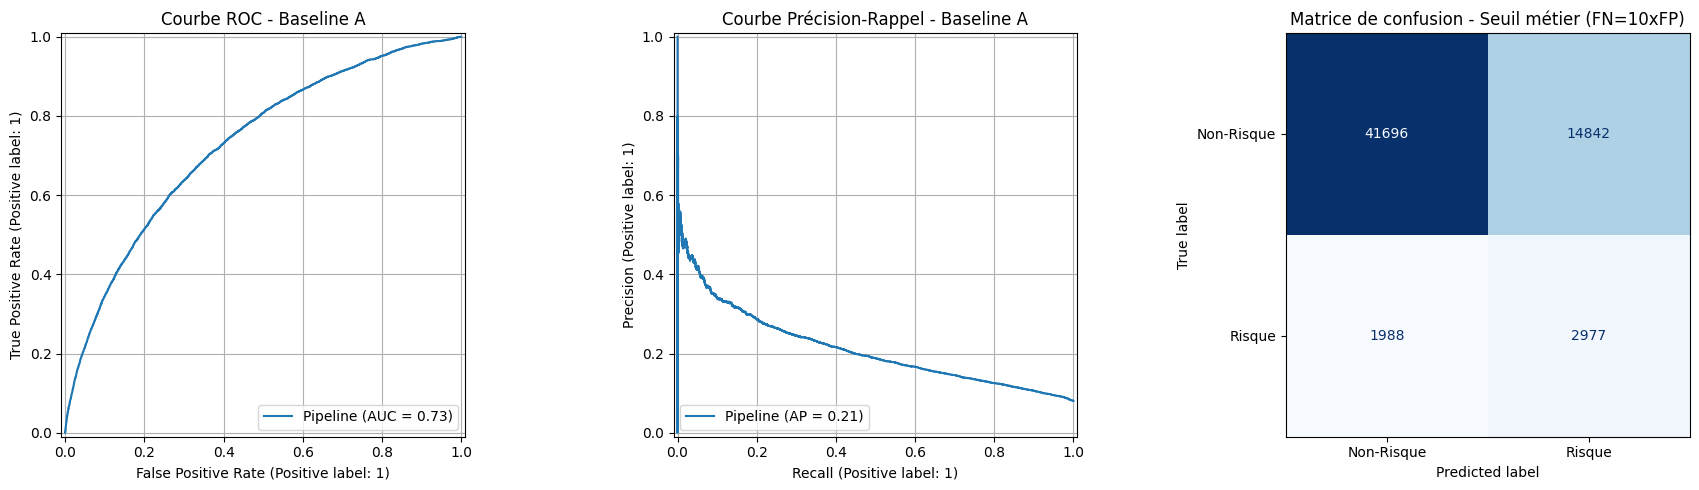

In [10]:
df = pd.read_csv(ROOT / "data" / "processed" / "train_features_v1.csv")
features = [
    "credit_income_perc", "annuity_income_perc", "goods_price_income_perc",
    "age_years", "employed_years",
    "ext1", "ext2", "ext3",
    "cnt_children", "cnt_family_members",
    "is_new_to_credit"
]
create_baseline("Baseline_A",df,features)

ROC AUC  = 0.733
PR AUC   = 0.216

Seuil métier choisi : 0.513
Coût total (FN=10xFP): 34670
Confusion : TP=3174 | FP=16760 | FN=1791 | TN=39778
Modèle Baseline_B + méta enregistrés.


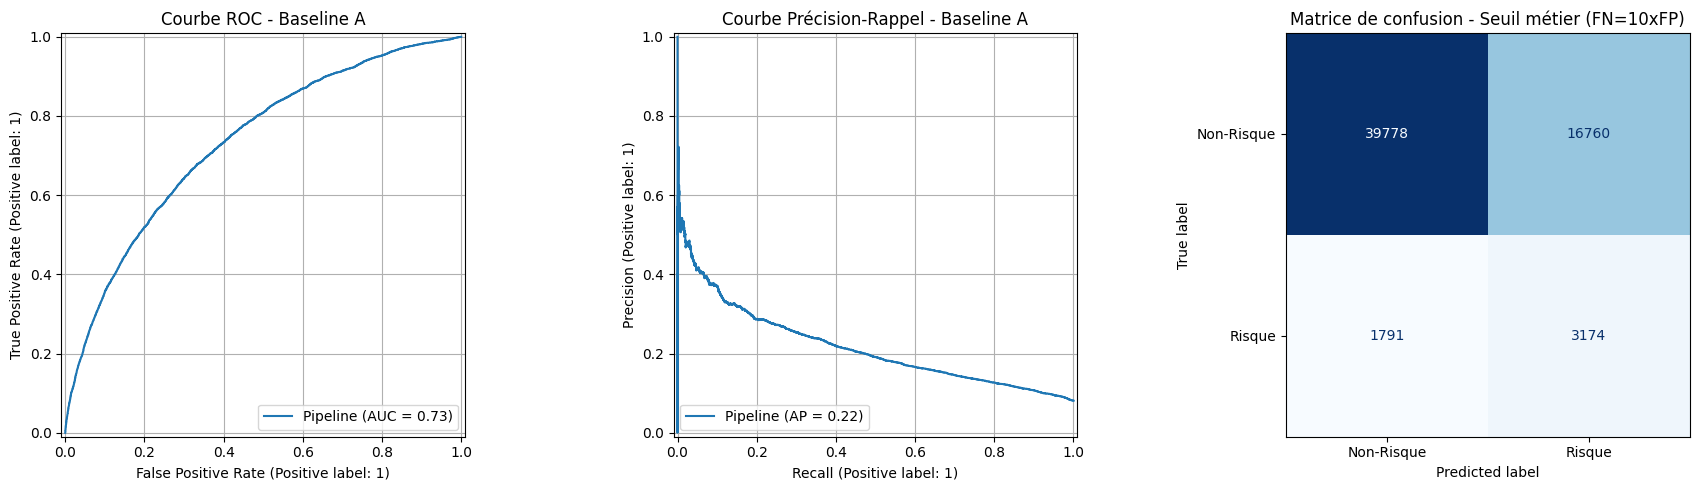

In [11]:
# Baseline B — Modèle sur toutes les features personnelles et historique + seuil métier (FN = 10×FP)

df = pd.read_csv(ROOT / "data" / "processed" / "train_features_v1.csv")
features = [
    'credit_income_perc', 'annuity_income_perc', 'goods_price_income_perc',
    'age_years', 'employed_years',
    'ext1', 'ext2', 'ext3',
    'cnt_children', 'cnt_family_members', 'n_prev_apps',
    'is_new_to_credit',
    'n_bureau', 'n_bureau_months',
    'n_prev', 'n_inst_pay', 'n_pos_cash', 'n_ccb'
]
create_baseline("Baseline_B",df,features)
